# Capacity allocation

In [1]:
!python3 -m pip install -e /home/oreto2024/PycharmProjects/robin

Python was not found; run without arguments to install from the Microsoft Store, or disable this shortcut from Settings > Apps > Advanced app settings > App execution aliases.


## 0. Load libraries

In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd

from benchmarks.generator import get_revenue_behavior, get_revenue_behavior_deprecated
from benchmarks.robin_railway import RevenueMaximization
from benchmarks.utils import sns_box_plot, sns_line_plot, int_input, get_schedule_from_supply, infer_line_stations, get_services_by_tsp_df, plot_marey_chart
from src.entities import GSA, Solution
from src.timetabling_problem import MPTT

from robin.scraping.entities import SupplySaver
from robin.services_generator.entities import ServiceGenerator
from robin.supply.entities import Service, Supply

from mealpy.evolutionary_based import GA
from mealpy import IntegerVar
from pathlib import Path
import shutil
from typing import Any, List, Mapping, Tuple, Union

In [3]:
# Config files
supply_config_path = Path("../configs/generator/supply_config.yml")
demand_config_path = Path("../configs/demand/demand.yml")
generator_config_path = Path("../configs/generator/generator_config.yml")

# Save paths
generator_save_path = Path(f'../data/generator/supply_dummy.yml')
supply_save_path = '../configs/mealpy/'
robin_save_path = '../data/output/robin/'
figures = '../figures/'

# Clean save paths directories
if Path(generator_save_path.parent).exists():
    shutil.rmtree(generator_save_path.parent)

Path(generator_save_path.parent).mkdir(parents=True)

if Path(supply_save_path).exists():
    shutil.rmtree(supply_save_path)
    
Path(supply_save_path).mkdir(parents=True)

#if Path(figures).exists():
#    shutil.rmtree(figures)
#Path(figures).mkdir(parents=True)

In [4]:
frame_capacity = {'1': 0.55, '2': 0.25, '3': 0.1, '4': 0.05, '5': 0.05}

n_services = 50
n_services_by_ru = {ru: round(cap * n_services) for ru, cap in frame_capacity.items()}

n_services_by_ru

{'1': 28, '2': 12, '3': 5, '4': 2, '5': 2}

In [5]:
seed = 21

if generator_config_path:
    generator = ServiceGenerator(supply_config_path=supply_config_path)
    _ = generator.generate(file_name=generator_save_path,
                           path_config=generator_config_path,
                           n_services_by_ru=n_services_by_ru,
                           seed=seed)
    print(f'Number of service requests generated: {len(_)}')

Number of service requests generated: 49


In [6]:
supply = Supply.from_yaml(generator_save_path)
tsp_df = get_services_by_tsp_df(supply.services)
print(tsp_df)

     Number of Services
RU1                  28
RU2                  12
RU3                   5
RU4                   2
RU5                   2


In [7]:
print("Services: ", len(supply.services))
requested_schedule = get_schedule_from_supply(generator_save_path)
revenue_behavior = get_revenue_behavior_deprecated(supply)
lines = supply.lines
line = infer_line_stations(lines)

Services:  49


In [8]:
n_services = sum(tsp_df["Number of Services"].values)

services_by_ru = {}
for service in revenue_behavior:
    if revenue_behavior[service]['ru'] not in services_by_ru:
        services_by_ru[revenue_behavior[service]['ru']] = 1
    else:
        services_by_ru[revenue_behavior[service]['ru']] += 1

services_by_ru = {f"RU{k}": v for k, v in services_by_ru.items()}
print(services_by_ru)

frame_capacity = {ru: round(services_by_ru[ru] / n_services * 100, 2) for ru in services_by_ru}
print(frame_capacity)

{'RU1': 28, 'RU2': 12, 'RU3': 5, 'RU4': 2, 'RU5': 2}
{'RU1': 57.14, 'RU2': 24.49, 'RU3': 10.2, 'RU4': 4.08, 'RU5': 4.08}


C:\Users\hyper\PycharmProjects\GSA_M\.venv\lib\site-packages\descartes\patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([


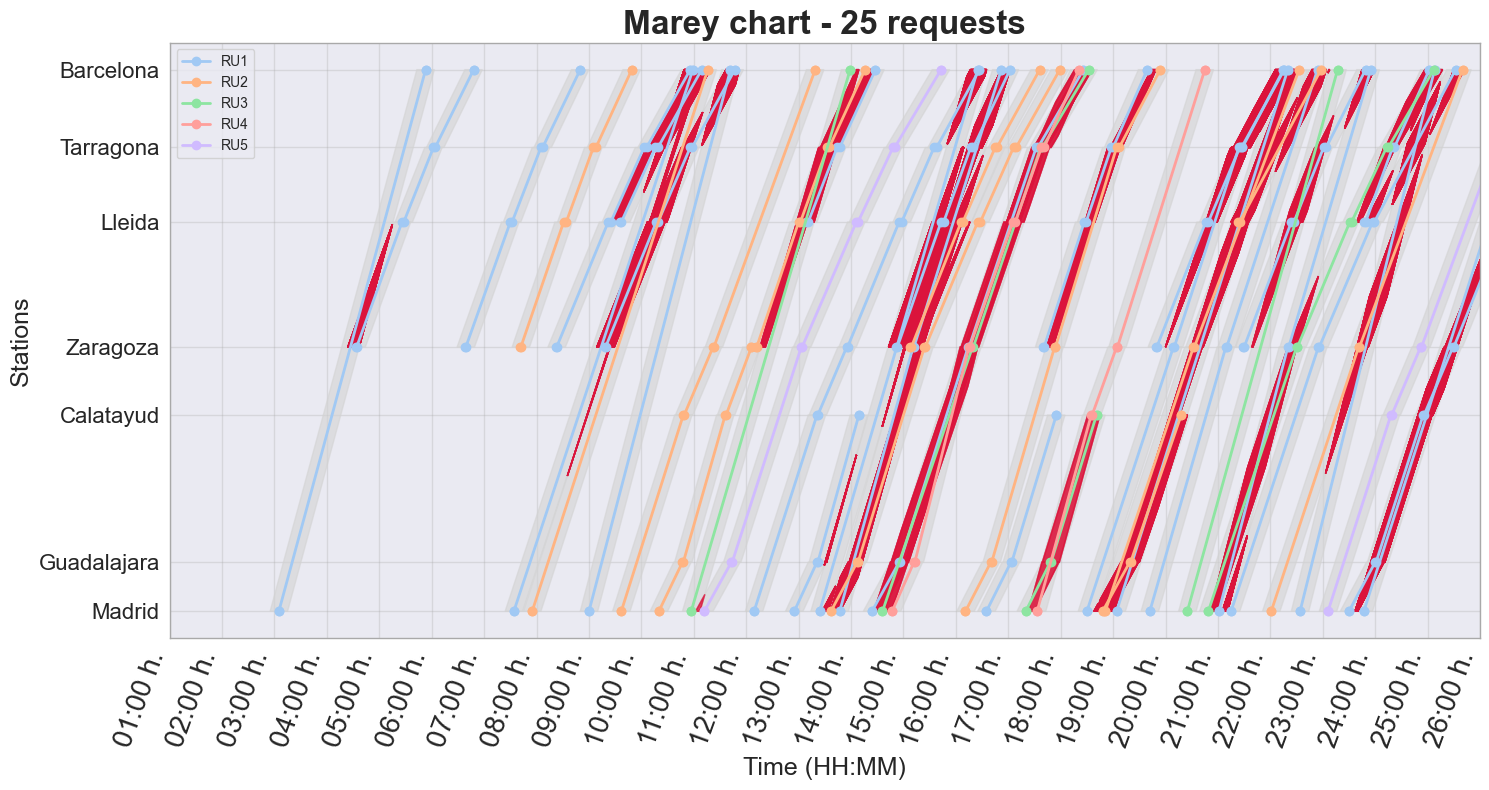

In [9]:
plot_marey_chart(requested_supply=supply,
                 colors_by_tsp=True, 
                 main_title="Marey chart - 25 requests",
                 plot_security_gaps=True,
                 security_gap=10,
                 save_path=Path('../reports/mealpy/marey_chart_requests_25.pdf'))

## 1. Mealpy

In [9]:
alpha_values = {"Revenue": 1, "Jain": 25, "Gini": 10, "Atkinson": 25}

In [10]:
# ------------------------------------------------------------------------------
# Configuration
# ------------------------------------------------------------------------------

runs = 5
epochs = 100
pop_size = 50
seed_initializer = 29
fair_indices = ["Revenue", "Jain", "Gini", "Atkinson"]

# ------------------------------------------------------------------------------
# Data Collection Containers
# ------------------------------------------------------------------------------
# Lists to accumulate history and population data from each run.
history_data = []
population_data = []
population_real = [f'real_{i}' for i in range(pop_size)]
population_discrete = [f'discrete_{i}' for i in range(pop_size)]
population_columns = ['Run', 'FairIndex', 'Iteration'] + population_real + population_discrete

# ------------------------------------------------------------------------------
# 1. Iterate over Algorithms and Runs
# ------------------------------------------------------------------------------
for fair_index in fair_indices:
    # Reset random seed for reproducibility per algorithm
    np.random.seed(seed_initializer)
    print(f"Running {fair_index}")

    alpha = 25 if fair_index in ["Jain", "Atkinson"] else 10
    mptt = MPTT(requested_schedule=requested_schedule,
                revenue_behavior=revenue_behavior,
                line=line,
                safe_headway=10,
                fair_index=fair_index,
                alpha=alpha)

    # ------------------------------------------------------------------------------
    # 0. Problem Formulation
    # ------------------------------------------------------------------------------
    lb, ub = zip(*mptt.boundaries.real)
    problem = {
        "obj_func": mptt.objective_function,
        "bounds": IntegerVar(lb=lb, ub=ub),
        "minmax": "max",
        "save_population": True
    }

    for run in range(1, runs + 1):
        print(f"\tRun: {run}")
        run_seed = np.random.randint(0, 1000)

        # Initialize and run the optimizer with appropriate parameters.
        optimizer = GA.BaseGA(epoch=epochs, pop_size=pop_size)
        optimizer.solve(problem, seed=run_seed)

        # ---------------------------
        # Build History Data
        # ---------------------------
        for iteration, data in enumerate(optimizer.history.list_global_best):
            # Update schedule so that the latest heuristic schedule is available.
            mptt.update_schedule(data.solution)

            # Build a dictionary for this iteration
            history_data.append({
                "Run": run,
                "FairIndex": fair_index,
                "Iteration": iteration,
                "Fitness": data.target.fitness,
                "ExecutionTime": optimizer.history.list_epoch_time[iteration],
                "Discrete": mptt.get_heuristic_schedule_new() if fair_index != "Revenue" else mptt.get_heuristic_schedule_old(),
                "Real": data.solution,
                "Diversity": optimizer.history.list_diversity[iteration],
                "Exploitation": optimizer.history.list_exploitation[iteration],
                "Exploration": optimizer.history.list_exploration[iteration],
            })

        # ---------------------------
        # Build Population Data
        # ---------------------------
        for i, pop_epoch in enumerate(optimizer.history.list_population):
            population_dict = {"Run": run, "FairIndex": fair_index, "Iteration": i}
            # Aquí usamos un contador 'j' para indexar cada individuo en el pop_epoch
            for j, individual in enumerate(pop_epoch):
                mptt.update_schedule(individual.solution)
                population_dict[f'real_{j}'] = individual.solution
                population_dict[f'discrete_{j}'] = (mptt.get_heuristic_schedule_new()
                                                    if fair_index != "Revenue"
                                                    else mptt.get_heuristic_schedule_old())
            population_data.append(population_dict)

# ------------------------------------------------------------------------------
# 2. Build Final DataFrames
# ------------------------------------------------------------------------------
# Create the history DataFrame from the list of dictionaries.
df_history = pd.DataFrame(history_data)
# Optionally, enforce a specific column order:
df_history = df_history[[
    "Run", "FairIndex", "Iteration", "Fitness", "ExecutionTime",
    "Discrete", "Real", "Diversity", "Exploitation", "Exploration"
]]

df_population = pd.DataFrame(population_data)
df_population = df_population[population_columns]

2025/03/09 08:33:26 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: Solving single objective optimization problem.


Running Revenue
	Run: 1


2025/03/09 08:33:28 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 1, Current best: 2661.7331687164396, Global best: 2661.7331687164396, Runtime: 0.81186 seconds
2025/03/09 08:33:28 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 2, Current best: 2679.0208864806955, Global best: 2679.0208864806955, Runtime: 0.81583 seconds
2025/03/09 08:33:29 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 3, Current best: 3088.6956619430944, Global best: 3088.6956619430944, Runtime: 0.81557 seconds
2025/03/09 08:33:30 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 4, Current best: 3178.7896371631173, Global best: 3178.7896371631173, Runtime: 0.81993 seconds
2025/03/09 08:33:31 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 5, Current best: 3596.3237426540713, Global best: 3596.3237426540713, Runtime: 0.81414 seconds
2025/03/09 08:33:32 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P

	Run: 2


2025/03/09 08:36:08 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 1, Current best: 2648.67122117909, Global best: 2648.67122117909, Runtime: 0.80300 seconds
2025/03/09 08:36:09 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 2, Current best: 3045.3674124910476, Global best: 3045.3674124910476, Runtime: 0.80964 seconds
2025/03/09 08:36:10 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 3, Current best: 3225.49764388692, Global best: 3225.49764388692, Runtime: 0.80990 seconds
2025/03/09 08:36:10 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 4, Current best: 3479.9267753584218, Global best: 3479.9267753584218, Runtime: 0.80953 seconds
2025/03/09 08:36:11 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 5, Current best: 3636.8872775412397, Global best: 3636.8872775412397, Runtime: 0.80747 seconds
2025/03/09 08:36:12 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch:

	Run: 3


2025/03/09 08:38:49 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 1, Current best: 2372.1071353997036, Global best: 2372.1071353997036, Runtime: 0.80526 seconds
2025/03/09 08:38:50 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 2, Current best: 2577.7717675795193, Global best: 2577.7717675795193, Runtime: 0.81361 seconds
2025/03/09 08:38:51 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 3, Current best: 2644.0842306780396, Global best: 2644.0842306780396, Runtime: 0.81724 seconds
2025/03/09 08:38:52 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 4, Current best: 3172.0944662560423, Global best: 3172.0944662560423, Runtime: 0.81237 seconds
2025/03/09 08:38:53 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 5, Current best: 3437.114692648835, Global best: 3437.114692648835, Runtime: 0.81131 seconds
2025/03/09 08:38:53 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, 

	Run: 4


2025/03/09 08:41:31 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 1, Current best: 2840.624181450914, Global best: 2840.624181450914, Runtime: 0.81221 seconds
2025/03/09 08:41:32 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 2, Current best: 3268.4733267254464, Global best: 3268.4733267254464, Runtime: 0.81440 seconds
2025/03/09 08:41:33 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 3, Current best: 3000.471541919851, Global best: 3268.4733267254464, Runtime: 0.80840 seconds
2025/03/09 08:41:34 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 4, Current best: 3141.1603442663095, Global best: 3268.4733267254464, Runtime: 0.80671 seconds
2025/03/09 08:41:34 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 5, Current best: 3378.851929148158, Global best: 3378.851929148158, Runtime: 0.81610 seconds
2025/03/09 08:41:35 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epo

	Run: 5


2025/03/09 08:44:12 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 1, Current best: 2565.7689989637047, Global best: 2565.7689989637047, Runtime: 0.80158 seconds
2025/03/09 08:44:13 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 2, Current best: 2784.0897024531237, Global best: 2784.0897024531237, Runtime: 0.80738 seconds
2025/03/09 08:44:13 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 3, Current best: 3703.182800344618, Global best: 3703.182800344618, Runtime: 0.81059 seconds
2025/03/09 08:44:14 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 4, Current best: 3950.1621081257913, Global best: 3950.1621081257913, Runtime: 0.81398 seconds
2025/03/09 08:44:15 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 5, Current best: 3857.008285443067, Global best: 3950.1621081257913, Runtime: 0.82443 seconds
2025/03/09 08:44:16 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, E

Running Jain
	Run: 1


2025/03/09 08:46:54 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 1, Current best: 1428.8998902565747, Global best: 1428.8998902565747, Runtime: 0.84154 seconds
2025/03/09 08:46:55 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 2, Current best: 1220.000118692108, Global best: 1428.8998902565747, Runtime: 0.84764 seconds
2025/03/09 08:46:56 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 3, Current best: 1320.1171312516603, Global best: 1428.8998902565747, Runtime: 0.85867 seconds
2025/03/09 08:46:57 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 4, Current best: 1456.701840428636, Global best: 1456.701840428636, Runtime: 0.84873 seconds
2025/03/09 08:46:57 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 5, Current best: 1257.2182443367103, Global best: 1456.701840428636, Runtime: 0.85090 seconds
2025/03/09 08:46:58 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Ep

	Run: 2


2025/03/09 08:49:44 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 1, Current best: 977.3476327238807, Global best: 977.3476327238807, Runtime: 0.83602 seconds
2025/03/09 08:49:45 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 2, Current best: 1182.405716491475, Global best: 1182.405716491475, Runtime: 0.84789 seconds
2025/03/09 08:49:45 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 3, Current best: 1119.5722619609396, Global best: 1182.405716491475, Runtime: 0.84797 seconds
2025/03/09 08:49:46 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 4, Current best: 1378.828489360767, Global best: 1378.828489360767, Runtime: 0.84145 seconds
2025/03/09 08:49:47 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 5, Current best: 1616.7992721806766, Global best: 1616.7992721806766, Runtime: 0.83950 seconds
2025/03/09 08:49:48 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch

	Run: 3


2025/03/09 08:52:32 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 1, Current best: 1062.234375335548, Global best: 1062.234375335548, Runtime: 0.83364 seconds
2025/03/09 08:52:33 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 2, Current best: 1126.8732920160483, Global best: 1126.8732920160483, Runtime: 0.85307 seconds
2025/03/09 08:52:33 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 3, Current best: 970.809052157952, Global best: 1126.8732920160483, Runtime: 0.85095 seconds
2025/03/09 08:52:34 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 4, Current best: 1263.575524809944, Global best: 1263.575524809944, Runtime: 0.85753 seconds
2025/03/09 08:52:35 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 5, Current best: 1398.3938352117962, Global best: 1398.3938352117962, Runtime: 0.85288 seconds
2025/03/09 08:52:36 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoc

	Run: 4


2025/03/09 08:55:23 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 1, Current best: 1013.8952458788564, Global best: 1013.8952458788564, Runtime: 0.84178 seconds
2025/03/09 08:55:24 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 2, Current best: 857.0576008222112, Global best: 1013.8952458788564, Runtime: 0.85207 seconds
2025/03/09 08:55:25 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 3, Current best: 1070.52366520368, Global best: 1070.52366520368, Runtime: 0.84380 seconds
2025/03/09 08:55:26 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 4, Current best: 1592.5983090858576, Global best: 1592.5983090858576, Runtime: 0.85156 seconds
2025/03/09 08:55:27 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 5, Current best: 1272.2945037027926, Global best: 1592.5983090858576, Runtime: 0.85096 seconds
2025/03/09 08:55:28 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epo

	Run: 5


2025/03/09 08:58:14 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 1, Current best: 824.5631926027069, Global best: 956.9781596536578, Runtime: 0.83295 seconds
2025/03/09 08:58:15 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 2, Current best: 1209.9728799427928, Global best: 1209.9728799427928, Runtime: 0.84327 seconds
2025/03/09 08:58:16 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 3, Current best: 1142.4090316475479, Global best: 1209.9728799427928, Runtime: 0.83821 seconds
2025/03/09 08:58:17 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 4, Current best: 1330.950750682854, Global best: 1330.950750682854, Runtime: 0.83812 seconds
2025/03/09 08:58:18 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 5, Current best: 1695.9854061648784, Global best: 1695.9854061648784, Runtime: 0.84902 seconds
2025/03/09 08:58:18 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Ep

Running Gini
	Run: 1


2025/03/09 09:01:02 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 1, Current best: 1052.3711546282123, Global best: 1163.200751421423, Runtime: 0.84718 seconds
2025/03/09 09:01:03 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 2, Current best: 1249.9942174750465, Global best: 1249.9942174750465, Runtime: 0.83643 seconds
2025/03/09 09:01:03 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 3, Current best: 1490.3497096542767, Global best: 1490.3497096542767, Runtime: 0.84962 seconds
2025/03/09 09:01:04 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 4, Current best: 1448.860054918454, Global best: 1490.3497096542767, Runtime: 0.84680 seconds
2025/03/09 09:01:05 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 5, Current best: 1817.4772343138861, Global best: 1817.4772343138861, Runtime: 0.85004 seconds
2025/03/09 09:01:06 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, 

	Run: 2


2025/03/09 09:03:51 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 1, Current best: 1205.467104861073, Global best: 1205.7102606284639, Runtime: 0.83997 seconds
2025/03/09 09:03:52 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 2, Current best: 1476.65124470899, Global best: 1476.65124470899, Runtime: 0.85141 seconds
2025/03/09 09:03:53 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 3, Current best: 1535.255125758034, Global best: 1535.255125758034, Runtime: 0.85357 seconds
2025/03/09 09:03:54 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 4, Current best: 1745.057735955029, Global best: 1745.057735955029, Runtime: 0.84917 seconds
2025/03/09 09:03:54 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 5, Current best: 2069.743082911874, Global best: 2069.743082911874, Runtime: 0.84677 seconds
2025/03/09 09:03:55 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 6,

	Run: 3


2025/03/09 09:06:42 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 1, Current best: 1571.6399998815814, Global best: 1571.6399998815814, Runtime: 0.83652 seconds
2025/03/09 09:06:43 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 2, Current best: 1526.6832131628917, Global best: 1571.6399998815814, Runtime: 0.85483 seconds
2025/03/09 09:06:43 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 3, Current best: 1555.855487912089, Global best: 1571.6399998815814, Runtime: 0.85466 seconds
2025/03/09 09:06:44 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 4, Current best: 1676.6430972250748, Global best: 1676.6430972250748, Runtime: 0.85415 seconds
2025/03/09 09:06:45 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 5, Current best: 1917.631175057627, Global best: 1917.631175057627, Runtime: 0.85749 seconds
2025/03/09 09:06:46 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, E

	Run: 4


2025/03/09 09:09:30 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 1, Current best: 1398.7480972477551, Global best: 1398.7480972477551, Runtime: 0.84766 seconds
2025/03/09 09:09:31 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 2, Current best: 1255.5224311462134, Global best: 1398.7480972477551, Runtime: 0.84750 seconds
2025/03/09 09:09:32 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 3, Current best: 1391.6587765561235, Global best: 1398.7480972477551, Runtime: 0.85154 seconds
2025/03/09 09:09:33 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 4, Current best: 1394.9802899695944, Global best: 1398.7480972477551, Runtime: 0.85480 seconds
2025/03/09 09:09:33 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 5, Current best: 1632.709751523081, Global best: 1632.709751523081, Runtime: 0.85371 seconds
2025/03/09 09:09:34 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, 

	Run: 5


2025/03/09 09:12:20 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 1, Current best: 1308.9609794260318, Global best: 1308.9609794260318, Runtime: 0.84150 seconds
2025/03/09 09:12:21 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 2, Current best: 1308.9609794260318, Global best: 1308.9609794260318, Runtime: 0.85308 seconds
2025/03/09 09:12:21 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 3, Current best: 1668.6900485115061, Global best: 1668.6900485115061, Runtime: 0.85232 seconds
2025/03/09 09:12:22 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 4, Current best: 1367.3249438837527, Global best: 1668.6900485115061, Runtime: 0.84137 seconds
2025/03/09 09:12:23 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 5, Current best: 1662.8820379757412, Global best: 1668.6900485115061, Runtime: 0.83400 seconds
2025/03/09 09:12:24 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P

Running Atkinson
	Run: 1


2025/03/09 09:15:07 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 1, Current best: 1693.1682047227284, Global best: 1693.1682047227284, Runtime: 0.83975 seconds
2025/03/09 09:15:08 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 2, Current best: 1349.3662876593426, Global best: 1693.1682047227284, Runtime: 0.84036 seconds
2025/03/09 09:15:09 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 3, Current best: 1577.0660970000226, Global best: 1693.1682047227284, Runtime: 0.84832 seconds
2025/03/09 09:15:09 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 4, Current best: 1577.6429333155857, Global best: 1693.1682047227284, Runtime: 0.84597 seconds
2025/03/09 09:15:10 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 5, Current best: 1765.8936275967492, Global best: 1765.8936275967492, Runtime: 0.85404 seconds
2025/03/09 09:15:11 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P

	Run: 2


2025/03/09 09:17:58 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 1, Current best: 1323.6131398950638, Global best: 1323.6131398950638, Runtime: 0.83502 seconds
2025/03/09 09:17:59 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 2, Current best: 1329.5790405383725, Global best: 1329.5790405383725, Runtime: 0.83986 seconds
2025/03/09 09:17:59 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 3, Current best: 1447.0679293953651, Global best: 1447.0679293953651, Runtime: 0.82842 seconds
2025/03/09 09:18:00 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 4, Current best: 1687.4672780308192, Global best: 1687.4672780308192, Runtime: 0.84081 seconds
2025/03/09 09:18:01 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 5, Current best: 1797.500688944178, Global best: 1797.500688944178, Runtime: 0.83883 seconds
2025/03/09 09:18:02 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, 

	Run: 3


2025/03/09 09:20:45 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 1, Current best: 1595.8937037675958, Global best: 1595.8937037675958, Runtime: 0.84421 seconds
2025/03/09 09:20:46 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 2, Current best: 1458.4995683048478, Global best: 1595.8937037675958, Runtime: 0.85787 seconds
2025/03/09 09:20:47 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 3, Current best: 1576.6892371984372, Global best: 1595.8937037675958, Runtime: 0.86203 seconds
2025/03/09 09:20:48 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 4, Current best: 1852.7720365270443, Global best: 1852.7720365270443, Runtime: 0.86011 seconds
2025/03/09 09:20:48 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 5, Current best: 2285.0282221501816, Global best: 2285.0282221501816, Runtime: 0.86275 seconds
2025/03/09 09:20:49 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P

	Run: 4


2025/03/09 09:23:34 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 1, Current best: 1467.9127194983762, Global best: 1467.9127194983762, Runtime: 0.83865 seconds
2025/03/09 09:23:35 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 2, Current best: 1121.7802740234333, Global best: 1467.9127194983762, Runtime: 0.84047 seconds
2025/03/09 09:23:36 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 3, Current best: 1375.4302480163096, Global best: 1467.9127194983762, Runtime: 0.84937 seconds
2025/03/09 09:23:37 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 4, Current best: 1636.4239555715333, Global best: 1636.4239555715333, Runtime: 0.84818 seconds
2025/03/09 09:23:38 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 5, Current best: 1490.0316994627808, Global best: 1636.4239555715333, Runtime: 0.84569 seconds
2025/03/09 09:23:38 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P

	Run: 5


2025/03/09 09:26:23 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 1, Current best: 1292.6459626939193, Global best: 1292.6459626939193, Runtime: 0.84047 seconds
2025/03/09 09:26:24 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 2, Current best: 1647.489480706857, Global best: 1647.489480706857, Runtime: 0.84819 seconds
2025/03/09 09:26:25 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 3, Current best: 1629.2259092018437, Global best: 1647.489480706857, Runtime: 0.84540 seconds
2025/03/09 09:26:26 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 4, Current best: 2141.4495916519854, Global best: 2141.4495916519854, Runtime: 0.84628 seconds
2025/03/09 09:26:27 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 5, Current best: 2213.494667900214, Global best: 2213.494667900214, Runtime: 0.84856 seconds
2025/03/09 09:26:27 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epo

## 2. Results analysis

In [17]:
reports_path = Path('../reports/mealpy')

In [20]:
file_name = "opti_alpha_unbalanced"

In [21]:
df_history.to_csv(reports_path / f'df_history_equity_{file_name}.csv', sep=";", index=False)
df_population.to_csv(reports_path / f'df_population_equity_{file_name}.csv', sep=";", index=False)

In [22]:
df_history = pd.read_csv(reports_path / f'df_history_equity_{file_name}.csv', sep=";")
df_population = pd.read_csv(reports_path / f'df_population_equity_{file_name}.csv', sep=";")

In [23]:
df_history

,Run,FairIndex,Iteration,Fitness,ExecutionTime,Discrete,Real,Diversity,Exploitation,Exploration
0,1,Revenue,0,2661.733169,0.811864,[False True False False False False False Tr...,[1033. 1111. 1141. 1358. 1446. 1498. 1537. 159...,11.845512,0.000000,100.000000
1,1,Revenue,1,2679.020886,0.815826,[False True False False False False False Tr...,[1041. 1114. 1147. 1407. 1446. 1501. 1537. 159...,10.355118,12.581927,87.418073
2,1,Revenue,2,3088.695662,0.815572,[False True False False False False False Fal...,[1041. 1111. 1146. 1407. 1444. 1498. 1532. 159...,9.795906,17.302809,82.697191
3,1,Revenue,3,3178.789637,0.819934,[False True False True False False False Tr...,[1033. 1114. 1143. 1407. 1446. 1501. 1537. 159...,8.647244,26.999827,73.000173
4,1,Revenue,4,3596.323743,0.814140,[False True False False False False False Tr...,[1033. 1111. 1146. 1407. 1446. 1500. 1539. 159...,8.385669,29.208046,70.791954
...,...,...,...,...,...,...,...,...,...,...
1995,5,Atkinson,95,3954.854616,0.853632,[False False True False False False False Tr...,[1067. 1117. 1143. 1375. 1444. 1500. 1533. 159...,2.343465,81.127697,18.872303
1996,5,Atkinson,96,3954.854616,0.864754,[False False True False False False False Tr...,[1067. 1117. 1143. 1375. 1444. 1500. 1533. 159...,2.209449,82.206947,17.793053
1997,5,Atkinson,97,3954.854616,0.860240,[False False True False False False False Tr...,[1067. 1117. 1143. 1375. 1444. 1500. 1533. 159...,2.361732,80.980584,19.019416
1998,5,Atkinson,98,3954.854616,0.857956,[False False True False False False False Tr...,[1067. 1117. 1143. 1375. 1444. 1500. 1533. 159...,2.279213,81.645128,18.354872


In [24]:
df_population

,Run,FairIndex,Iteration,real_0,real_1,real_2,real_3,real_4,real_5,real_6,...,discrete_40,discrete_41,discrete_42,discrete_43,discrete_44,discrete_45,discrete_46,discrete_47,discrete_48,discrete_49
0,1,Revenue,0,[1068. 1115. 1145. 1383. 1443. 1502. 1536. 159...,[1096. 1109. 1144. 1460. 1446. 1501. 1531. 159...,[1064. 1112. 1142. 1456. 1448. 1498. 1531. 159...,[1033. 1115. 1147. 1358. 1444. 1498. 1537. 159...,[1039. 1114. 1141. 1456. 1443. 1502. 1539. 159...,[1096. 1111. 1144. 1416. 1446. 1496. 1531. 159...,[1100. 1114. 1147. 1358. 1446. 1503. 1532. 159...,...,[ True True False False False False False Tr...,[False True False False False False False Fal...,[False True False False False False False Fal...,[False True False False False False False Fal...,[False True False False True False False Fal...,[ True True False False False False False Tr...,[False True False False False False False Tr...,[False True False False False False False Tr...,[False True True False False True False Fal...,[False True False True False False False Tr...
1,1,Revenue,1,[1069. 1111. 1141. 1416. 1442. 1501. 1539. 159...,[1039. 1115. 1146. 1457. 1443. 1500. 1539. 159...,[1041. 1114. 1147. 1437. 1446. 1496. 1531. 159...,[1039. 1111. 1143. 1407. 1443. 1501. 1532. 159...,[1039. 1114. 1141. 1446. 1443. 1505. 1539. 159...,[1061. 1115. 1146. 1416. 1446. 1501. 1532. 159...,[1061. 1114. 1146. 1446. 1443. 1501. 1532. 159...,...,[False True False False False False False Tr...,[False True False True False False False Tr...,[False True False False False False False Fal...,[False True False False False False False Fal...,[False True False False False False False Fal...,[False True False False False False False Tr...,[False True False False False False False Tr...,[False True False False False False False Tr...,[False True False False False False False Fal...,[False True False False False False False Tr...
2,1,Revenue,2,[1041. 1111. 1143. 1407. 1446. 1501. 1537. 159...,[1069. 1114. 1147. 1437. 1442. 1500. 1531. 159...,[1041. 1114. 1146. 1426. 1446. 1498. 1531. 159...,[1033. 1111. 1143. 1407. 1446. 1501. 1537. 159...,[1041. 1111. 1143. 1437. 1442. 1501. 1531. 159...,[1069. 1114. 1146. 1407. 1446. 1500. 1531. 159...,[1069. 1111. 1141. 1416. 1442. 1501. 1539. 159...,...,[False True False False False False False Fal...,[False True False False False False False Fal...,[False True False False False False False Tr...,[False True False False False False False Tr...,[False True False False False False False Tr...,[False True False False False False False Tr...,[ True True False False False False False Tr...,[False True False False False False False Fal...,[False True False False False False False Fal...,[False True False False False False False Fal...
3,1,Revenue,3,[1061. 1111. 1146. 1446. 1446. 1498. 1532. 159...,[1039. 1111. 1141. 1358. 1443. 1498. 1537. 159...,[1039. 1111. 1141. 1358. 1450. 1496. 1537. 159...,[1033. 1111. 1146. 1437. 1446. 1504. 1532. 159...,[1071. 1111. 1143. 1407. 1446. 1496. 1537. 159...,[1033. 1111. 1141. 1358. 1446. 1501. 1531. 159...,[1039. 1110. 1143. 1358. 1446. 1496. 1538. 159...,...,[False True False False False False False Tr...,[False True False False False False False Fal...,[False True False True False False False Tr...,[False True False False False False False Tr...,[False True False False False False False Tr...,[ True True False False False False False Fal...,[False True False True False False False Tr...,[False True False False False False False Tr...,[False True False True False False False Fal...,[False True False False False False False Tr...
4,1,Revenue,4,[1069. 1111. 1141. 1457. 1443. 1498. 1539. 159...,[1041. 1111. 1141. 1437. 1444. 1500. 1532. 159...,[1033. 1111. 1141. 1358. 1443. 1496. 1539. 159...,[1033. 1111. 1141. 1437. 1446. 1500. 1532. 159...,[1033. 1111. 1143. 1407. 1446. 1503. 1537. 159...,[1033. 1114. 1146. 1407. 1446. 1501. 1532. 159...,[1041. 1111. 1143. 1407. 1443. 1500. 1531. 159...,...,[False True False False False Fal

In [25]:
columns_to_transform = df_population.filter(like="real_").columns

df_population[columns_to_transform] = df_population[columns_to_transform].apply(
    lambda col: col.map(lambda x: list(map(float, x[1:-1].split())))
)

df_population.head()

,Run,FairIndex,Iteration,real_0,real_1,real_2,real_3,real_4,real_5,real_6,...,discrete_40,discrete_41,discrete_42,discrete_43,discrete_44,discrete_45,discrete_46,discrete_47,discrete_48,discrete_49
0,1,Revenue,0,"[1068.0, 1115.0, 1145.0, 1383.0, 1443.0, 1502....","[1096.0, 1109.0, 1144.0, 1460.0, 1446.0, 1501....","[1064.0, 1112.0, 1142.0, 1456.0, 1448.0, 1498....","[1033.0, 1115.0, 1147.0, 1358.0, 1444.0, 1498....","[1039.0, 1114.0, 1141.0, 1456.0, 1443.0, 1502....","[1096.0, 1111.0, 1144.0, 1416.0, 1446.0, 1496....","[1100.0, 1114.0, 1147.0, 1358.0, 1446.0, 1503....",...,[ True True False False False False False Tr...,[False True False False False False False Fal...,[False True False False False False False Fal...,[False True False False False False False Fal...,[False True False False True False False Fal...,[ True True False False False False False Tr...,[False True False False False False False Tr...,[False True False False False False False Tr...,[False True True False False True False Fal...,[False True False True False False False Tr...
1,1,Revenue,1,"[1069.0, 1111.0, 1141.0, 1416.0, 1442.0, 1501....","[1039.0, 1115.0, 1146.0, 1457.0, 1443.0, 1500....","[1041.0, 1114.0, 1147.0, 1437.0, 1446.0, 1496....","[1039.0, 1111.0, 1143.0, 1407.0, 1443.0, 1501....","[1039.0, 1114.0, 1141.0, 1446.0, 1443.0, 1505....","[1061.0, 1115.0, 1146.0, 1416.0, 1446.0, 1501....","[1061.0, 1114.0, 1146.0, 1446.0, 1443.0, 1501....",...,[False True False False False False False Tr...,[False True False True False False False Tr...,[False True False False False False False Fal...,[False True False False False False False Fal...,[False True False False False False False Fal...,[False True False False False False False Tr...,[False True False False False False False Tr...,[False True False False False False False Tr...,[False True False False False False False Fal...,[False True False False False False False Tr...
2,1,Revenue,2,"[1041.0, 1111.0, 1143.0, 1407.0, 1446.0, 1501....","[1069.0, 1114.0, 1147.0, 1437.0, 1442.0, 1500....","[1041.0, 1114.0, 1146.0, 1426.0, 1446.0, 1498....","[1033.0, 1111.0, 1143.0, 1407.0, 1446.0, 1501....","[1041.0, 1111.0, 1143.0, 1437.0, 1442.0, 1501....","[1069.0, 1114.0, 1146.0, 1407.0, 1446.0, 1500....","[1069.0, 1111.0, 1141.0, 1416.0, 1442.0, 1501....",...,[False True False False False False False Fal...,[False True False False False False False Fal...,[False True False False False False False Tr...,[False True False False False False False Tr...,[False True False False False False False Tr...,[False True False False False False False Tr...,[ True True False False False False False Tr...,[False True False False False False False Fal...,[False True False False False False False Fal...,[False True False False False False False Fal...
3,1,Revenue,3,"[1061.0, 1111.0, 1146.0, 1446.0, 1446.0, 1498....","[1039.0, 1111.0, 1141.0, 1358.0, 1443.0, 1498....","[1039.0, 1111.0, 1141.0, 1358.0, 1450.0, 1496....","[1033.0, 1111.0, 1146.0, 1437.0, 1446.0, 1504....","[1071.0, 1111.0, 1143.0, 1407.0, 1446.0, 1496....","[1033.0, 1111.0, 1141.0, 1358.0, 1446.0, 1501....","[1039.0, 1110.0, 1143.0, 1358.0, 1446.0, 1496....",...,[False True False False False False False Tr...,[False True False False False False False Fal...,[False True False True False False False Tr...,[False True False False False False False Tr...,[False True False False False False False Tr...,[ True True False False False False False Fal...,[False True False True False False False Tr...,[False True False False False False False Tr...,[False True False True False False False Fal...,[False True False False False False False Tr...
4,1,Revenue,4,"[1069.0, 1111.0, 1141.0, 1457.0, 1443.0, 1498....","[1041.0, 1111.0, 1141.0, 1437.0, 1444.0, 1500....","[1033.0, 1111.0, 1141.0, 1358.0, 1443.0, 1496....","[1033.0, 1111.0, 1141.0, 1437.0, 1446.0, 1500....","[1033.0, 1111.0, 1143.0, 1407.0, 1446.0, 1503....","[1033.0, 1114.0, 1146.0, 1407.0, 1446.0, 1501....","[1041.0, 1111.0, 1

In [26]:
columns_to_transform = df_population.filter(like="discrete_").columns

df_population[columns_to_transform] = df_population[columns_to_transform].apply(
    lambda col: col.map(lambda x: list(map(lambda x: 1 if x == "True" else 0, x[1:-1].split())))
)

df_population.head()

,Run,FairIndex,Iteration,real_0,real_1,real_2,real_3,real_4,real_5,real_6,...,discrete_40,discrete_41,discrete_42,discrete_43,discrete_44,discrete_45,discrete_46,discrete_47,discrete_48,discrete_49
0,1,Revenue,0,"[1068.0, 1115.0, 1145.0, 1383.0, 1443.0, 1502....","[1096.0, 1109.0, 1144.0, 1460.0, 1446.0, 1501....","[1064.0, 1112.0, 1142.0, 1456.0, 1448.0, 1498....","[1033.0, 1115.0, 1147.0, 1358.0, 1444.0, 1498....","[1039.0, 1114.0, 1141.0, 1456.0, 1443.0, 1502....","[1096.0, 1111.0, 1144.0, 1416.0, 1446.0, 1496....","[1100.0, 1114.0, 1147.0, 1358.0, 1446.0, 1503....",...,"[1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, ...","[0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, ...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...","[0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, ...","[1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, ...","[0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, ...","[0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, ...","[0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, ...","[0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, ..."
1,1,Revenue,1,"[1069.0, 1111.0, 1141.0, 1416.0, 1442.0, 1501....","[1039.0, 1115.0, 1146.0, 1457.0, 1443.0, 1500....","[1041.0, 1114.0, 1147.0, 1437.0, 1446.0, 1496....","[1039.0, 1111.0, 1143.0, 1407.0, 1443.0, 1501....","[1039.0, 1114.0, 1141.0, 1446.0, 1443.0, 1505....","[1061.0, 1115.0, 1146.0, 1416.0, 1446.0, 1501....","[1061.0, 1114.0, 1146.0, 1446.0, 1443.0, 1501....",...,"[0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, ...","[0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, ...","[0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, ...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, ...","[0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, ...","[0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, ...","[0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, ...","[0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, ..."
2,1,Revenue,2,"[1041.0, 1111.0, 1143.0, 1407.0, 1446.0, 1501....","[1069.0, 1114.0, 1147.0, 1437.0, 1442.0, 1500....","[1041.0, 1114.0, 1146.0, 1426.0, 1446.0, 1498....","[1033.0, 1111.0, 1143.0, 1407.0, 1446.0, 1501....","[1041.0, 1111.0, 1143.0, 1437.0, 1442.0, 1501....","[1069.0, 1114.0, 1146.0, 1407.0, 1446.0, 1500....","[1069.0, 1111.0, 1141.0, 1416.0, 1442.0, 1501....",...,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, ...","[0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, ...","[0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, ...","[0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, ...","[0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, ...","[1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, ...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, ...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, ...","[0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, ..."
3,1,Revenue,3,"[1061.0, 1111.0, 1146.0, 1446.0, 1446.0, 1498....","[1039.0, 1111.0, 1141.0, 1358.0, 1443.0, 1498....","[1039.0, 1111.0, 1141.0, 1358.0, 1450.0, 1496....","[1033.0, 1111.0, 1146.0, 1437.0, 1446.0, 1504....","[1071.0, 1111.0, 1143.0, 1407.0, 1446.0, 1496....","[1033.0, 1111.0, 1141.0, 1358.0, 1446.0, 1501....","[1039.0, 1110.0, 1143.0, 1358.0, 1446.0, 1496....",...,"[0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...","[0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, ...","[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, ...","[0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, ...","[0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, ...","[0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, ...","[0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, ..."
4,1,Revenue,4,"[1069.0, 1111.0, 1141.0, 1457.0, 1443.0, 1498....","[1041.0, 1111.0, 1141.0, 1437.0, 1444.0, 1500....","[1033.0, 1111.0, 1141.0, 1358.0, 1443.0, 1496....","[1033.0, 1111.0, 1141.0

In [27]:
# Transformar columnas con Real y Discrete después de leer el .csv
from src.timetabling_problem import MPTT

# Define new revenue maximization object for results analysis
mptt = MPTT(requested_schedule=requested_schedule,
            revenue_behavior=revenue_behavior,
            line=line,
            safe_headway=10)

columns_to_transform = df_history.filter(like="Real").columns

# Sum 1 to Iteration column values
df_history['Iteration'] += 1

df_history[columns_to_transform] = df_history[columns_to_transform].apply(
    lambda col: col.map(lambda x: np.array(list(map(float, x[1:-1].split())), dtype=np.int32))
)

columns_to_transform = df_history.filter(like="Discrete").columns

df_history[columns_to_transform] = df_history[columns_to_transform].apply(
    lambda col: col.map(lambda x: np.array(list(map(lambda s: True if s == "True" else False, x[1:-1].split())), dtype=bool))
)

# Incluir columnas con beneficio
df_history['Revenue'] = df_history['Real'].apply(mptt.objective_function)
df_history.head()

,Run,FairIndex,Iteration,Fitness,ExecutionTime,Discrete,Real,Diversity,Exploitation,Exploration,Revenue
0,1,Revenue,1,2661.733169,0.811864,"[False, True, False, False, False, False, Fals...","[1033, 1111, 1141, 1358, 1446, 1498, 1537, 159...",11.845512,0.000000,100.000000,2661.733169
1,1,Revenue,2,2679.020886,0.815826,"[False, True, False, False, False, False, Fals...","[1041, 1114, 1147, 1407, 1446, 1501, 1537, 159...",10.355118,12.581927,87.418073,2679.020886
2,1,Revenue,3,3088.695662,0.815572,"[False, True, False, False, False, False, Fals...","[1041, 1111, 1146, 1407, 1444, 1498, 1532, 159...",9.795906,17.302809,82.697191,3088.695662
3,1,Revenue,4,3178.789637,0.819934,"[False, True, False, True, False, False, False...","[1033, 1114, 1143, 1407, 1446, 1501, 1537, 159...",8.647244,26.999827,73.000173,3178.789637
4,1,Revenue,5,3596.323743,0.814140,"[False, True, False, False, False, False, Fals...","[1033, 1111, 1146, 1407, 1446, 1500, 1539, 159...",8.385669,29.208046,70.791954,3596.323743


In [28]:
# Function to compute fitness

# Mapeo de servicios a nombres de RU (por ejemplo, "RU1", "RU2", etc.)
service_tsps = {service.id: service.tsp.name for service in supply.services}
ru_names = sorted(set(service_tsps.values()))

def fitness_from_real(x: np.array) -> float:
    return mptt.objective_function(x)

max_ineq = (len(ru_names)**2) / 4 if len(ru_names) % 2 == 0 else (len(ru_names) // 2) * ((len(ru_names) + 1) // 2)

def pairwise_diff_from_discrete(scheduled_trains_array) -> float:
    # Obtener el diccionario de importancias (por RU) a partir del vector booleano de servicios planificados.
    importance_dict = mptt.sum_importance(scheduled_trains_array)
    importance_dict = {f'RU{k}': v for k, v in importance_dict.items()}

    # Calcular la suma de diferencias absolutas pairwise entre las importancias.
    pairwise_diff = 0
    for ru1, ru2 in itertools.combinations(ru_names, 2):
        pairwise_diff += abs(importance_dict.get(ru1, 0) - importance_dict.get(ru2, 0))

    return round(pairwise_diff / max_ineq * 100, 2)

def jain_index_from_discrete(scheduled, alpha) -> float:
    return mptt.jain_fairness_index(scheduled, mptt.capacities, alpha)[0]

def gini_index_from_discrete(scheduled, alpha) -> float:
    return mptt.gini_fairness_index(scheduled, mptt.capacities, alpha)[0]

def atkinson_index_from_discrete(scheduled, alpha) -> float:
    return mptt.atkinson_fairness_index(scheduled, mptt.capacities, alpha)[0]

In [29]:
import itertools

def get_plot_df(df: pd.DataFrame,
                map_function_selector: str = "Inequity") -> pd.DataFrame:
    filter_fair_index = ("Revenue", "Jain", "Gini", "Atkinson")

    # Create dataframe with fitness values for each individual of the population
    df_pop = df[df['FairIndex'].isin(filter_fair_index)]

    set_filtered_algos = set(df_pop["FairIndex"])
    print(f"Filtered algos: {set_filtered_algos}")

    df_pop = df_pop.replace(r'\n', ' ', regex=True)

    # Iterate through the dataframe and apply the function with progress feedback
    previous_run, previous_algo = None, None

    for index, row in df_pop.iterrows():
        current_run = row['Run']
        current_algo = row['FairIndex']
        real_solution = row

        # Print message if there's a change in 'Run' or 'FairIndex'
        if current_run != previous_run or current_algo != previous_algo:
            print(f"Processing new combination: Run = {current_run}, FairIndex = {current_algo}")
            previous_run, previous_algo = current_run, current_algo

        if map_function_selector == "Inequity":
            map_function = pairwise_diff_from_discrete
        else:
            # Apply the fitness function to the real columns
            if current_algo == "Jain":
                map_function = lambda x: jain_index_from_discrete(x, alpha_values[current_algo])
            elif current_algo == "Gini":
                map_function = lambda x: gini_index_from_discrete(x, alpha_values[current_algo])
            elif current_algo == "Atkinson":
                map_function = lambda x: atkinson_index_from_discrete(x, alpha_values[current_algo])
            else:
                map_function = lambda x: 1

        # Apply the fitness function to the real columns
        df_pop.loc[index, 'Inequity'] = map_function(row['Discrete'])

    print("Processing completed.")

    # Prepare dataframe for boxplot
    rows = []
    for row in df_pop.iterrows():
        run = row[1]['Run']
        iteration = row[1]['Iteration']
        fair_index = row[1]['FairIndex']

        inequity = row[1]['Inequity']
        rows.append({'Run': run, 'Iteration': iteration, 'Inequity': inequity, 'FairIndex': fair_index})

    return pd.DataFrame.from_dict(rows, orient='columns')

Filtered algos: {'Jain', 'Atkinson', 'Gini'}
Processing new combination: Run = 1, FairIndex = Jain
Processing new combination: Run = 2, FairIndex = Jain
Processing new combination: Run = 3, FairIndex = Jain
Processing new combination: Run = 4, FairIndex = Jain
Processing new combination: Run = 5, FairIndex = Jain
Processing new combination: Run = 1, FairIndex = Gini
Processing new combination: Run = 2, FairIndex = Gini
Processing new combination: Run = 3, FairIndex = Gini
Processing new combination: Run = 4, FairIndex = Gini
Processing new combination: Run = 5, FairIndex = Gini
Processing new combination: Run = 1, FairIndex = Atkinson
Processing new combination: Run = 2, FairIndex = Atkinson
Processing new combination: Run = 3, FairIndex = Atkinson
Processing new combination: Run = 4, FairIndex = Atkinson
Processing new combination: Run = 5, FairIndex = Atkinson
Processing completed.


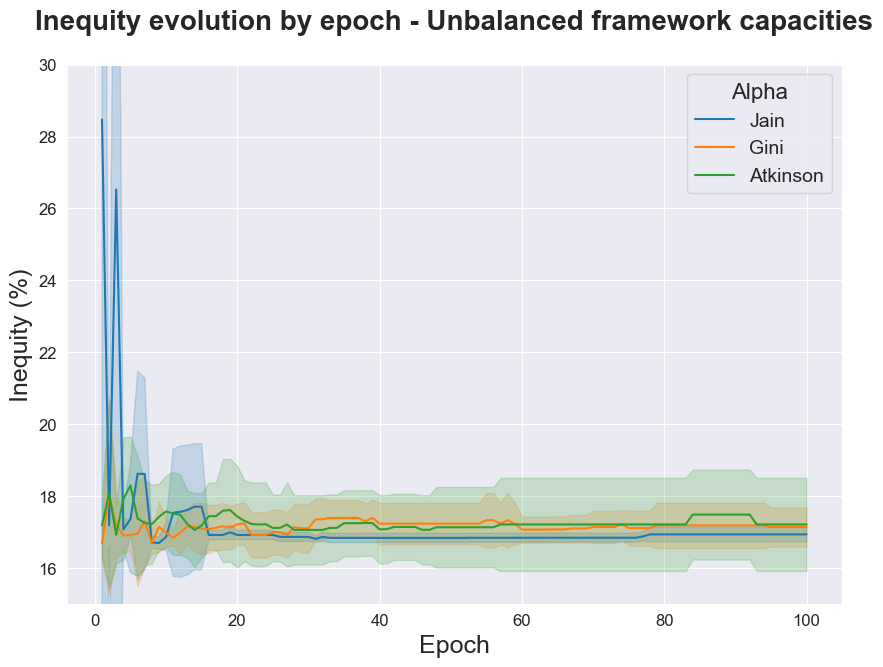

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt

df_history_filtered = df_history[df_history['FairIndex'] != "Revenue"]

plt.figure(figsize=(10, 7))
sns.lineplot(
    data=get_plot_df(df_history_filtered, map_function_selector="Inequity"),
    x="Iteration",
    y="Inequity",
    hue="FairIndex",
    estimator="mean",
    errorbar="sd",  # Standard deviation
    marker=None
)

plt.legend(title="Fair Index")

plt.title("Inequity evolution by epoch - Unbalanced framework capacities",
          y=1.05,
          fontsize=20,
          fontweight='bold')

plt.xlabel("Epoch", fontsize=18)
plt.ylabel("Inequity (%)", fontsize=18)

plt.ylim((15, 30))

plt.tick_params(axis='both', labelsize=12)
# Agregar una única leyenda fuera del área de los gráficos
plt.legend(fontsize=14, title="Alpha", title_fontsize=16)

# Guardar el gráfico como PDF
plt.savefig("../reports/mealpy/figures/inequity_unbalanced_evo.pdf", format="pdf", bbox_inches="tight")

plt.show()

Filtered algos: {'Jain', 'Atkinson', 'Gini'}
Processing new combination: Run = 1, FairIndex = Jain
Processing new combination: Run = 2, FairIndex = Jain
Processing new combination: Run = 3, FairIndex = Jain
Processing new combination: Run = 4, FairIndex = Jain
Processing new combination: Run = 5, FairIndex = Jain
Processing new combination: Run = 1, FairIndex = Gini
Processing new combination: Run = 2, FairIndex = Gini
Processing new combination: Run = 3, FairIndex = Gini
Processing new combination: Run = 4, FairIndex = Gini
Processing new combination: Run = 5, FairIndex = Gini
Processing new combination: Run = 1, FairIndex = Atkinson
Processing new combination: Run = 2, FairIndex = Atkinson
Processing new combination: Run = 3, FairIndex = Atkinson
Processing new combination: Run = 4, FairIndex = Atkinson
Processing new combination: Run = 5, FairIndex = Atkinson
Processing completed.


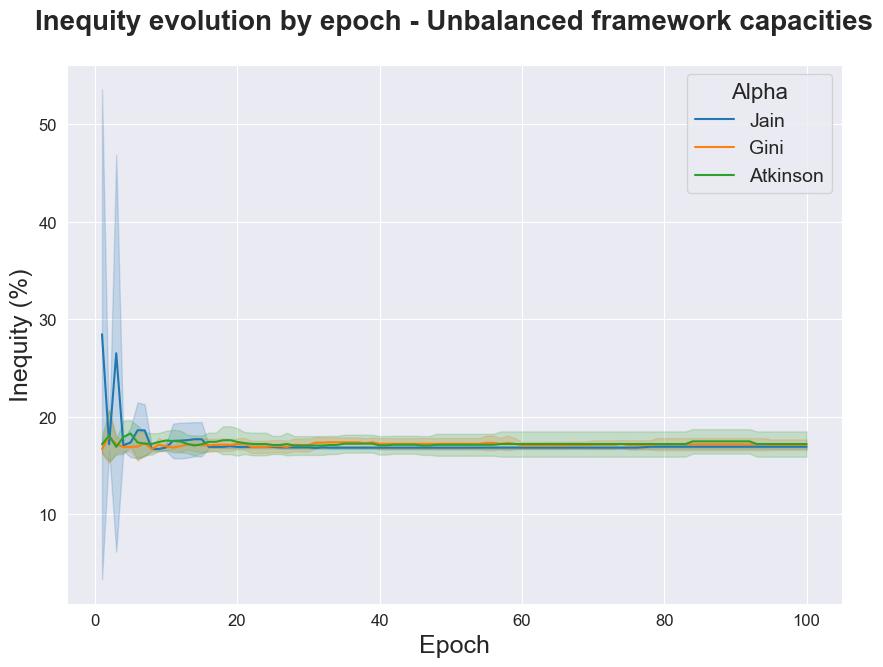

In [35]:
df_history_filtered = df_history[df_history['FairIndex'] != "Revenue"]

plt.figure(figsize=(10, 7))
sns.lineplot(
    data=get_plot_df(df_history_filtered, map_function_selector="Inequity"),
    x="Iteration",
    y="Inequity",
    hue="FairIndex",
    estimator="mean",
    errorbar="sd",  # Standard deviation
    marker=None
)

plt.legend(title="Fair Index")

plt.title("Inequity evolution by epoch - Unbalanced framework capacities",
          y=1.05,
          fontsize=20,
          fontweight='bold')

plt.xlabel("Epoch", fontsize=18)
plt.ylabel("Inequity (%)", fontsize=18)

plt.tick_params(axis='both', labelsize=12)
# Agregar una única leyenda fuera del área de los gráficos
plt.legend(fontsize=14, title="Alpha", title_fontsize=16)

# Guardar el gráfico como PDF
plt.savefig("../reports/mealpy/figures/inequity_unbalanced_evo.pdf", format="pdf", bbox_inches="tight")

plt.show()

Filtered algos: {'Jain', 'Atkinson', 'Gini'}
Processing new combination: Run = 1, FairIndex = Jain
Processing new combination: Run = 2, FairIndex = Jain
Processing new combination: Run = 3, FairIndex = Jain
Processing new combination: Run = 4, FairIndex = Jain
Processing new combination: Run = 5, FairIndex = Jain
Processing new combination: Run = 1, FairIndex = Gini
Processing new combination: Run = 2, FairIndex = Gini
Processing new combination: Run = 3, FairIndex = Gini
Processing new combination: Run = 4, FairIndex = Gini
Processing new combination: Run = 5, FairIndex = Gini
Processing new combination: Run = 1, FairIndex = Atkinson
Processing new combination: Run = 2, FairIndex = Atkinson
Processing new combination: Run = 3, FairIndex = Atkinson
Processing new combination: Run = 4, FairIndex = Atkinson
Processing new combination: Run = 5, FairIndex = Atkinson
Processing completed.


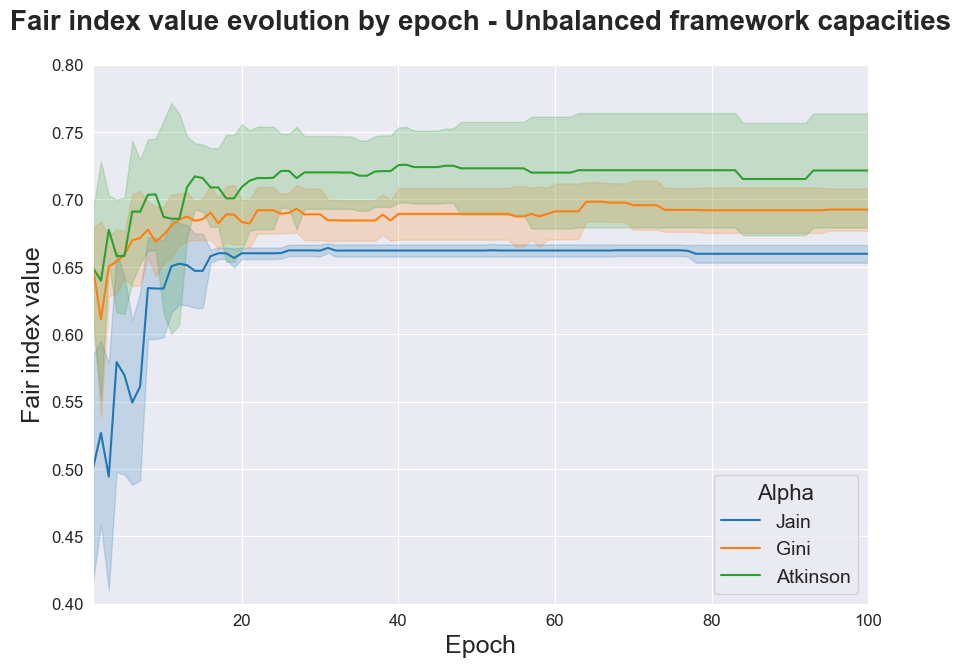

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))

df_filtered = df_history[df_history['FairIndex'] != "Revenue"]

sns.lineplot(
    data=get_plot_df(df_filtered, map_function_selector="Revenue"),
    x="Iteration",
    y="Inequity",
    hue="FairIndex",
    estimator="mean",
    errorbar="sd",  # Standard deviation
    marker=None
)

plt.legend(title="Fair Index")

plt.title("Fair index value evolution by epoch - Unbalanced framework capacities",
          y=1.05,
          fontsize=20,
          fontweight='bold')

plt.xlabel("Epoch", fontsize=18)
plt.ylabel("Fair index value", fontsize=18)

plt.tick_params(axis='both', labelsize=12)

plt.ylim((0.4, 0.8))
plt.xlim((1, 100))
# Agregar una única leyenda fuera del área de los gráficos
plt.legend(fontsize=14, title="Alpha", title_fontsize=16, loc="lower right")

# Guardar el gráfico como PDF
plt.savefig("../reports/mealpy/figures/unbalanced_fair_index_evo.pdf", format="pdf", bbox_inches="tight")

plt.show()

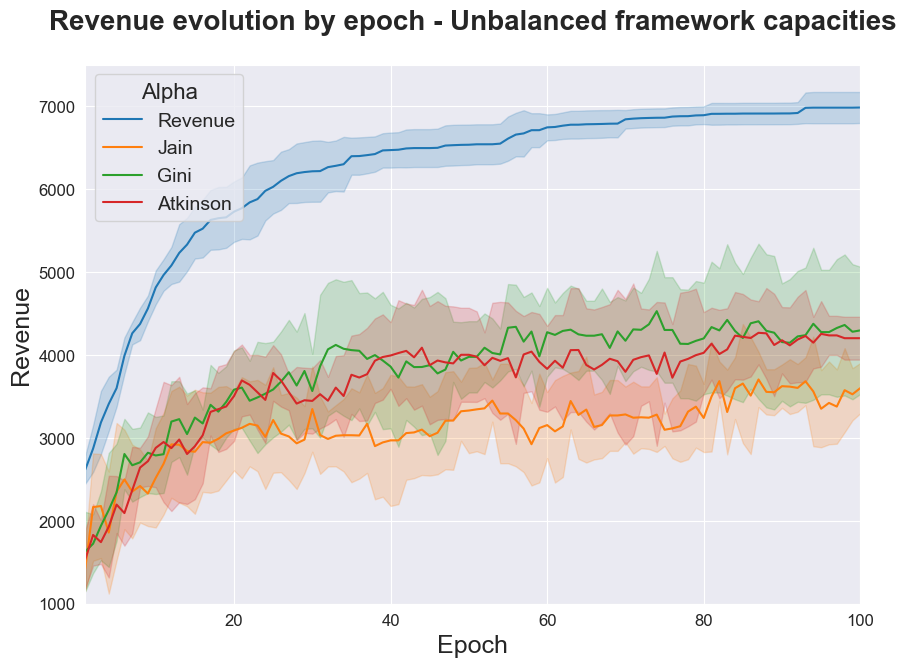

In [41]:
plt.figure(figsize=(10, 7))

# df_filtered = df_history[df_history['FairIndex'] != "Revenue"]

sns.lineplot(
    data=df_history,
    x="Iteration",
    y="Revenue",
    hue="FairIndex",
    estimator="mean",
    errorbar="sd",  # Standard deviation
    marker=None
)

plt.legend(title="Fair Index")

plt.title("Revenue evolution by epoch - Unbalanced framework capacities",
          y=1.05,
          fontsize=20,
          fontweight='bold')

plt.xlabel("Epoch", fontsize=18)
plt.ylabel("Revenue", fontsize=18)

plt.ylim((1000, 7500))
plt.xlim((1, 100))

plt.tick_params(axis='both', labelsize=12)
# Agregar una única leyenda fuera del área de los gráficos
plt.legend(fontsize=14, title="Alpha", title_fontsize=16, loc="upper left")

# Guardar el gráfico como PDF
plt.savefig("../reports/mealpy/figures/revenue_unbalanced_evo.pdf", format="pdf", bbox_inches="tight")

plt.show()

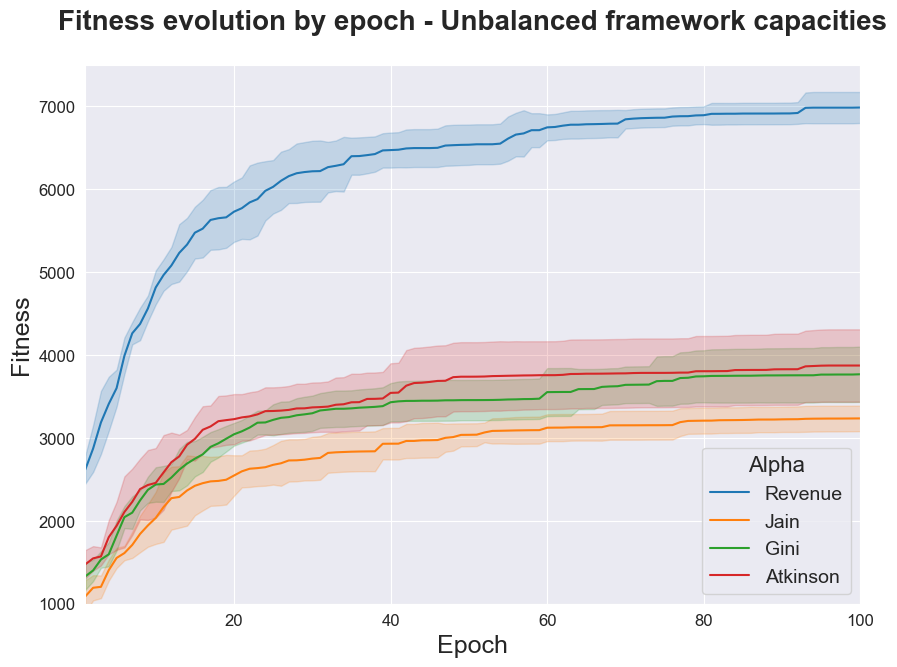

In [43]:
plt.figure(figsize=(10, 7))

# df_filtered = df_history[df_history['FairIndex'] != "Revenue"]

sns.lineplot(
    data=df_history,
    x="Iteration",
    y="Fitness",
    hue="FairIndex",
    estimator="mean",
    errorbar="sd",  # Standard deviation
    marker=None
)

plt.legend(title="Fair Index")

plt.title("Fitness evolution by epoch - Unbalanced framework capacities",
          y=1.05,
          fontsize=20,
          fontweight='bold')

plt.xlabel("Epoch", fontsize=18)
plt.ylabel("Fitness", fontsize=18)

plt.ylim((1000, 7500))
plt.xlim((1, 100))

plt.tick_params(axis='both', labelsize=12)
# Agregar una única leyenda fuera del área de los gráficos
plt.legend(fontsize=14, title="Alpha", title_fontsize=16, loc="lower right")

# Guardar el gráfico como PDF
plt.savefig("../reports/mealpy/figures/fitness_unbalanced_evo.pdf", format="pdf", bbox_inches="tight")

plt.show()

In [45]:
import itertools
import numpy as np
import pandas as pd

# Mapeo de servicios a nombres de RU (por ejemplo, "RU1", "RU2", etc.)
service_tsps = {service.id: service.tsp.name for service in supply.services}
ru_names = sorted(set(service_tsps.values()))

# Se asume que df_history tiene la columna 'Alpha'
# Además, se asume que ru_names y frame_capacity ya están definidos

# Definir las columnas del nuevo DataFrame (agregamos 'Alpha')
columns = ['FairIndex', 'Alpha', 'Run', 'Fitness', 'Revenue', 'Execution Time (s.)', 'Scheduled Trains'] + ru_names + ['Total Importance', 'Inequity', 'Assigned capacity']
summary_df = pd.DataFrame(columns=columns)

# Agrupar el historial por FairIndex y luego por Run
algo_grouped_df = df_history.groupby('FairIndex')
for algo_key, algo_group in algo_grouped_df:
    run_grouped_df = algo_group.groupby('Run')
    for run_label, run_group in run_grouped_df:
        run = run_group['Run'].iloc[-1]
        # Extraemos el valor de Alpha (suponiendo que es constante en cada run)
        alpha = alpha_values[algo_key]
        fitness = np.round(run_group['Fitness'].iloc[-1], 2)
        revenue = mptt.objective_function(run_group['Real'].iloc[-1])
        execution_time = np.round(run_group['ExecutionTime'].sum(), 2)
        scheduled_trains_array = run_group['Discrete'].iloc[-1]
        scheduled_trains = int(sum(scheduled_trains_array))
        real_solution = run_group['Real'].iloc[-1]

        # Actualizamos la planificación
        mptt.update_schedule(real_solution)

        # Obtener el diccionario de importancias (por RU)
        importance_dict = mptt.sum_importance(scheduled_trains_array)
        importance_dict = {f'RU{k}': v for k, v in importance_dict.items()}
        total_importance = sum(importance_dict.values())

        # Calcular la suma de diferencias absolutas pairwise entre las importancias.
        pairwise_diff = 0
        for ru1, ru2 in itertools.combinations(ru_names, 2):
            pairwise_diff += abs(importance_dict.get(ru1, 0) - importance_dict.get(ru2, 0))

        # Se calcula max_ineq de acuerdo al número de RU (usado para normalizar la inequidad)
        if len(ru_names) % 2 == 0:
            max_ineq = (len(ru_names)**2) / 4
        else:
            max_ineq = (len(ru_names) // 2) * ((len(ru_names) + 1) // 2)

        # Construir la fila de datos
        row_data = [
            algo_key,
            alpha,
            run,
            fitness,
            revenue,
            execution_time,
            scheduled_trains
        ]
        # Agregar, para cada RU, el valor de la importancia (en %)
        for ru in ru_names:
            row_data.append(round(importance_dict.get(ru, 0) * 100, 2))
        # Columna de Total Importance
        row_data.append(round(total_importance / len(ru_names) * 100, 2))
        # Columna de Inequity (normalizada)
        row_data.append(round(pairwise_diff / max_ineq * 100, 2))
        # Columna de Assigned capacity
        capacity_usage = 0.0
        for ru in ru_names:
            capacity_usage += importance_dict.get(ru, 0) * frame_capacity[ru]
        row_data.append(capacity_usage)

        summary_df.loc[len(summary_df)] = row_data

# Ordenamos o mostramos el DataFrame resumen si se desea
# display(summary_df)

# Ahora agrupamos por FairIndex y Alpha para obtener un resumen de la inequidad
df_summary = summary_df.groupby(['FairIndex', 'Alpha'])['Inequity'].agg(['mean', 'std']).reset_index()

# Opcional: redondeamos a dos decimales
df_summary[['mean', 'std']] = df_summary[['mean', 'std']].round(2)

print(df_summary)


  FairIndex  Alpha   mean   std
0  Atkinson     25  17.21  1.30
1      Gini     10  17.13  0.54
2      Jain     25  16.93  0.21
3   Revenue      1  76.74  0.96


In [46]:
import itertools

mptt = MPTT(
    requested_schedule=requested_schedule,
    revenue_behavior=revenue_behavior,
    line=line,
    safe_headway=10,
    fair_index="Revenue",
    alpha=25
)

# Mapeo de servicios a nombres de RU (por ejemplo, "RU1", "RU2", etc.)
service_tsps = {service.id: service.tsp.name for service in supply.services}
ru_names = sorted(set(service_tsps.values()))

# Definir las columnas del nuevo DataFrame:
# FairIndex, Run, Revenue, Execution Time (s.), Scheduled Trains + una columna por cada RU
columns = ['FairIndex', 'Run', 'Fitness', 'Revenue', 'Execution Time (s.)', 'Scheduled Trains'] + ru_names + ['Total Importance', 'Inequity', 'Assigned capacity']
summary_df = pd.DataFrame(columns=columns)

# Agrupar el historial por FairIndex y luego por Run
algo_grouped_df = df_history.groupby('FairIndex')

for algo_key, algo_group in algo_grouped_df:
    run_grouped_df = algo_group.groupby('Run')
    for run_label, run_group in run_grouped_df:
        run = run_group['Run'].iloc[-1]
        fitness = np.round(run_group['Fitness'].iloc[-1], 2)
        revenue = mptt.objective_function(run_group['Real'].iloc[-1])
        execution_time = np.round(run_group['ExecutionTime'].sum(), 2)
        scheduled_trains_array = run_group['Discrete'].iloc[-1]
        scheduled_trains = int(sum(scheduled_trains_array))
        real_solution = run_group['Real'].iloc[-1]

        # Actualizamos la planificación (por si el método .sum_importance() depende de ello)
        mptt.update_schedule(real_solution)

        # Obtener el diccionario de importancias (por RU) a partir del vector booleano de servicios planificados.
        importance_dict = mptt.sum_importance(scheduled_trains_array)
        importance_dict = {f'RU{k}': v for k, v in importance_dict.items()}

        total_importance = sum(importance_dict.values())

        # Calcular la suma de diferencias absolutas pairwise entre las importancias.
        pairwise_diff = 0
        for ru1, ru2 in itertools.combinations(ru_names, 2):
            pairwise_diff += abs(importance_dict.get(ru1, 0) - importance_dict.get(ru2, 0))

        # Construir la fila de datos:
        row_data = [
            algo_key,
            run,
            fitness,
            revenue,
            execution_time,
            scheduled_trains
        ]

        # Agregar, para cada RU (ordenados alfabéticamente), el valor de suma de importancia.
        for ru in ru_names:
            # Si no existe valor para algún RU, se asigna 0
            row_data.append(round(importance_dict.get(ru, 0) * 100, 2))

        # Agregar la columna de Total Importance
        max_ineq = (len(ru_names)**2) / 4 if len(ru_names) % 2 == 0 else (len(ru_names) // 2) * ((len(ru_names) + 1) // 2)
        row_data.append(round(total_importance / len(ru_names) * 100, 2))
        # Agregar la columna de Pairwise Differences
        row_data.append(round(pairwise_diff / max_ineq * 100, 2))

        capacity_usage = 0.0
        for ru in ru_names:
            capacity_usage += importance_dict.get(ru, 0) * frame_capacity[ru]
        row_data.append(capacity_usage)

        summary_df.loc[len(summary_df)] = row_data

summary_df = summary_df.sort_values('Inequity', ascending=True)
display(summary_df)
print()

,FairIndex,Run,Fitness,Revenue,Execution Time (s.),Scheduled Trains,RU1,RU2,RU3,RU4,RU5,Total Importance,Inequity,Assigned capacity
3,Atkinson,4,3930.47,4074.918042,85.83,22,47.68,48.28,45.94,25.67,49.24,43.36,16.49,46.808663
9,Gini,5,3892.86,4708.591163,85.13,24,48.52,47.70,45.94,25.67,49.24,43.41,16.58,47.146936
4,Atkinson,5,3954.85,4075.330035,85.40,23,48.18,48.68,45.94,25.67,49.24,43.54,16.63,47.191895
1,Atkinson,2,4113.50,4002.484420,85.03,24,48.58,48.78,45.94,25.67,49.24,43.64,16.66,47.446274
8,Gini,4,3359.80,3677.707254,86.26,23,48.85,48.84,45.94,25.67,49.24,43.70,16.69,47.612830
14,Jain,5,3332.87,3926.411109,85.01,23,48.93,48.75,45.94,25.67,49.24,43.70,16.71,47.640699
2,Atkinson,3,4239.20,4643.601522,86.29,25,48.98,48.90,45.94,25.67,49.24,43.74,16.73,47.705516
11,Jain,2,3395.49,3840.787728,85.16,24,48.78,49.12,45.94,25.67,49.24,43.75,16.78,47.646210
12,Jain,3,3023.41,3478.699305,87.04,22,48.76,49.37,45.94,25.67,49.24,43.80,16.90,47.696112
10,Jain,1,3293.40,3586.787285,86.06,24,49.56,49.12,45.94,25.67,49.24,43.91,17.03,48.092264


In [47]:
summary_df.to_latex()

'\\begin{tabular}{llrrrrrrrrrrrrr}\n\\toprule\n & FairIndex & Run & Fitness & Revenue & Execution Time (s.) & Scheduled Trains & RU1 & RU2 & RU3 & RU4 & RU5 & Total Importance & Inequity & Assigned capacity \\\\\n\\midrule\n3 & Atkinson & 4 & 3930.470000 & 4074.918042 & 85.830000 & 22 & 47.680000 & 48.280000 & 45.940000 & 25.670000 & 49.240000 & 43.360000 & 16.490000 & 46.808663 \\\\\n9 & Gini & 5 & 3892.860000 & 4708.591163 & 85.130000 & 24 & 48.520000 & 47.700000 & 45.940000 & 25.670000 & 49.240000 & 43.410000 & 16.580000 & 47.146936 \\\\\n4 & Atkinson & 5 & 3954.850000 & 4075.330035 & 85.400000 & 23 & 48.180000 & 48.680000 & 45.940000 & 25.670000 & 49.240000 & 43.540000 & 16.630000 & 47.191895 \\\\\n1 & Atkinson & 2 & 4113.500000 & 4002.484420 & 85.030000 & 24 & 48.580000 & 48.780000 & 45.940000 & 25.670000 & 49.240000 & 43.640000 & 16.660000 & 47.446274 \\\\\n8 & Gini & 4 & 3359.800000 & 3677.707254 & 86.260000 & 23 & 48.850000 & 48.840000 & 45.940000 & 25.670000 & 49.240000 & 43.7

In [48]:
# Global status

def get_global_status(df: pd.DataFrame):
    algo_grouped_df = df.groupby('FairIndex')

    for algo_group in algo_grouped_df:
        run_grouped_df = algo_group[1].groupby('Run')
        
        print(f"Global {algo_group[0]} status:")
        
        # Execution time (mean and std.)
        run_times = run_grouped_df['ExecutionTime'].last()
        print(f'\tTotal execution time: {round(run_times.sum(), 4)} s.')
        print(f'\tExecution Time (by run) - Mean: {round(run_times.mean(), 4)} s. - Std: {round(run_times.std(), 4)} s.')
        
        # Revenue (mean and std.)
        run_revenues = run_grouped_df['Fitness'].last()
        print(f'\tRevenue - Mean: {round(run_revenues.mean(), 4)} - Std: {round(run_revenues.std(), 4)}')
        
        # Scheduled trains (mean and std.)
        run_trains = run_grouped_df['Discrete'].last().apply(sum)
        print(f'\tScheduled Trains - Mean: {np.round(run_trains.mean())} - Std: {np.round(run_trains.std())}')
        
        max_revenue = sum([mptt.revenue[service]['canon'] for service in mptt.revenue])
        print(f"\tMax Revenue: {max_revenue} - WARNING!: Scheduling all services could not be feasible")
        print()
        
get_global_status(df_history)

Global Atkinson status:
	Total execution time: 4.3139 s.
	Execution Time (by run) - Mean: 0.8628 s. - Std: 0.004 s.
	Revenue - Mean: 3872.4581 - Std: 436.6209
	Scheduled Trains - Mean: 23.0 - Std: 1.0
	Max Revenue: 11585.75 - WARNING!: Scheduling all services could not be feasible

Global Gini status:
	Total execution time: 4.3151 s.
	Execution Time (by run) - Mean: 0.863 s. - Std: 0.0094 s.
	Revenue - Mean: 3767.1583 - Std: 333.793
	Scheduled Trains - Mean: 24.0 - Std: 1.0
	Max Revenue: 11585.75 - WARNING!: Scheduling all services could not be feasible

Global Jain status:
	Total execution time: 4.3052 s.
	Execution Time (by run) - Mean: 0.861 s. - Std: 0.0079 s.
	Revenue - Mean: 3234.6457 - Std: 154.0725
	Scheduled Trains - Mean: 23.0 - Std: 1.0
	Max Revenue: 11585.75 - WARNING!: Scheduling all services could not be feasible

Global Revenue status:
	Total execution time: 4.1357 s.
	Execution Time (by run) - Mean: 0.8271 s. - Std: 0.007 s.
	Revenue - Mean: 6984.2749 - Std: 186.9391
	S

In [49]:
# Lista de columnas que queremos agregar (excluyendo 'FairIndex' que es la clave de agrupación)
columnas_agg = ['Fitness', 'Revenue', 'Execution Time (s.)'] + ru_names + ['Total Importance', 'Inequity', 'Assigned capacity']

# Agrupamos por FairIndex y aplicamos las funciones de agregación 'mean' y 'std'
df_resultado = summary_df.groupby('FairIndex')[columnas_agg].agg(['mean', 'std'])

# Opcional: aplanamos los nombres de columnas para que queden en un formato más cómodo
df_resultado.columns = [f'{col[0]}_{col[1]}' for col in df_resultado.columns]
df_resultado.reset_index(inplace=True)

# Mostramos el dataframe resultante
display(df_resultado)

,FairIndex,Fitness_mean,Fitness_std,Revenue_mean,Revenue_std,Execution Time (s.)_mean,Execution Time (s.)_std,RU1_mean,RU1_std,RU2_mean,...,RU4_mean,RU4_std,RU5_mean,RU5_std,Total Importance_mean,Total Importance_std,Inequity_mean,Inequity_std,Assigned capacity_mean,Assigned capacity_std
0,Atkinson,3872.456,436.621982,4202.066103,258.436341,85.842,0.656635,49.022,1.567265,49.342,...,25.670,0.000000,49.24,0.0,43.840,0.619839,17.206,1.296507,47.836611,1.270426
1,Gini,3767.158,333.791956,4296.219524,767.779085,85.976,0.687481,49.514,0.858359,48.956,...,25.670,0.000000,49.24,0.0,43.860,0.320234,17.134,0.543581,48.023734,0.666794
2,Jain,3234.646,154.071414,3599.889010,302.947413,85.934,0.852807,49.158,0.468316,49.158,...,25.670,0.000000,49.24,0.0,43.834,0.125419,16.930,0.207244,47.871371,0.296512
3,Revenue,6984.274,186.939790,6984.274911,186.939079,82.260,0.499350,48.218,2.548739,75.670,...,85.134,33.241387,100.00,0.0,64.160,5.504430,76.736,0.964484,54.836725,1.638303


In [50]:
df_history.head()

,Run,FairIndex,Iteration,Fitness,ExecutionTime,Discrete,Real,Diversity,Exploitation,Exploration,Revenue
0,1,Revenue,1,2661.733169,0.811864,"[False, True, False, False, False, False, Fals...","[1033, 1111, 1141, 1358, 1446, 1498, 1537, 159...",11.845512,0.000000,100.000000,2661.733169
1,1,Revenue,2,2679.020886,0.815826,"[False, True, False, False, False, False, Fals...","[1041, 1114, 1147, 1407, 1446, 1501, 1537, 159...",10.355118,12.581927,87.418073,2679.020886
2,1,Revenue,3,3088.695662,0.815572,"[False, True, False, False, False, False, Fals...","[1041, 1111, 1146, 1407, 1444, 1498, 1532, 159...",9.795906,17.302809,82.697191,3088.695662
3,1,Revenue,4,3178.789637,0.819934,"[False, True, False, True, False, False, False...","[1033, 1114, 1143, 1407, 1446, 1501, 1537, 159...",8.647244,26.999827,73.000173,3178.789637
4,1,Revenue,5,3596.323743,0.814140,"[False, True, False, False, False, False, Fals...","[1033, 1111, 1146, 1407, 1446, 1500, 1539, 159...",8.385669,29.208046,70.791954,3596.323743


In [51]:
# Orden deseado de FairIndex
orden_fairindex = ["Revenue", "Jain", "Gini", "Atkinson"]

# 1. Agrupamos y agregamos (media y desviación) para las columnas numéricas
columnas_agg = ['Fitness', 'Revenue', 'Execution Time (s.)'] + ru_names + ['Total Importance', 'Inequity', 'Assigned capacity']
df_resultado = summary_df.groupby('FairIndex')[columnas_agg].agg(['mean', 'std'])

# 2. Aplanamos el MultiIndex de columnas para obtener nombres como 'Fitness_mean', 'Fitness_std', etc.
df_resultado.columns = [f'{col[0]}_{col[1]}' for col in df_resultado.columns]
df_resultado.reset_index(inplace=True)

# 3. Establecemos 'FairIndex' como índice y reordenamos según 'orden_fairindex'
df_resultado = df_resultado.set_index('FairIndex')
df_resultado = df_resultado.reindex(orden_fairindex)

# 4. Redondeamos todos los valores a dos decimales
df_resultado = df_resultado.round(2)

# 5. Transponemos el DataFrame para que las columnas se conviertan en filas
df_transpuesto = df_resultado.T

# 6. Convertimos el DataFrame transpuesto a tabla LaTeX
latex_table = df_transpuesto.to_latex(float_format='%.2f')

print(latex_table)

\begin{tabular}{lrrrr}
\toprule
FairIndex & Revenue & Jain & Gini & Atkinson \\
\midrule
Fitness_mean & 6984.27 & 3234.65 & 3767.16 & 3872.46 \\
Fitness_std & 186.94 & 154.07 & 333.79 & 436.62 \\
Revenue_mean & 6984.27 & 3599.89 & 4296.22 & 4202.07 \\
Revenue_std & 186.94 & 302.95 & 767.78 & 258.44 \\
Execution Time (s.)_mean & 82.26 & 85.93 & 85.98 & 85.84 \\
Execution Time (s.)_std & 0.50 & 0.85 & 0.69 & 0.66 \\
RU1_mean & 48.22 & 49.16 & 49.51 & 49.02 \\
RU1_std & 2.55 & 0.47 & 0.86 & 1.57 \\
RU2_mean & 75.67 & 49.16 & 48.96 & 49.34 \\
RU2_std & 9.03 & 0.27 & 0.81 & 1.54 \\
RU3_mean & 11.78 & 45.94 & 45.94 & 45.94 \\
RU3_std & 0.00 & 0.00 & 0.00 & 0.00 \\
RU4_mean & 85.13 & 25.67 & 25.67 & 25.67 \\
RU4_std & 33.24 & 0.00 & 0.00 & 0.00 \\
RU5_mean & 100.00 & 49.24 & 49.24 & 49.24 \\
RU5_std & 0.00 & 0.00 & 0.00 & 0.00 \\
Total Importance_mean & 64.16 & 43.83 & 43.86 & 43.84 \\
Total Importance_std & 5.50 & 0.13 & 0.32 & 0.62 \\
Inequity_mean & 76.74 & 16.93 & 17.13 & 17.21 \\
Inequit

In [43]:
def get_global_status_as_dataframe(df: pd.DataFrame):
    algo_grouped_df = df.groupby('FairIndex')
    
    results = []
    for algo_name, algo_group in algo_grouped_df:
        run_grouped_df = algo_group.groupby('Run')
        
        run_times = run_grouped_df['ExecutionTime'].sum()
        
        run_fitness = run_grouped_df['Fitness'].last()
        run_trains = run_grouped_df['Discrete'].last().apply(sum)
        
        result = {
            'FairIndex': algo_name,
            'Mean Execution Time (seconds)': round(run_times.mean(), 2),
            'Std Execution Time (seconds)': round(run_times.std(), 2),
            'Mean Fitness': round(run_fitness.mean(), 2),
            'Std Fitness': round(run_fitness.std(), 2),
            'Mean Scheduled Trains': int(round(run_trains.mean())),
            'Std Scheduled Trains': int(round(run_trains.std()))
        }
        
        results.append(result)
    
    results_df = pd.DataFrame(results)
    
    # Short by column 'Mean Fitness' 
    results_df = results_df.sort_values(by='Mean Fitness (revenue)', ascending=False).reset_index(drop=True)
    return results_df

results_df = get_global_status_as_dataframe(df_history)
results_df

,FairIndex,Mean Execution Time (seconds),Std Execution Time (seconds),Mean Fitness (revenue),Std Fitness (revenue),Mean Scheduled Trains,Std Scheduled Trains
0,Revenue,102.05,2.02,6295.91,443.27,26,2
1,Atkinson,106.69,0.67,3501.00,354.92,21,1
2,Gini,105.98,0.95,3487.09,397.93,21,1
3,Jain,104.96,1.28,3465.53,198.90,21,1


In [ ]:
results_df.to_latex()